## Import library

packages allowed for use during inference

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torchvision

import imageio as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from modules_v1 import UNet_conditional
from P1_CustomDataset import P1_CustomDataset
from P1_CombinedDataset import P1_CombinedDataset

packages during training

## Hyperparameters

In [2]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


## Define Custom Dataset

training dataset的mean & std

In [3]:
train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]

建train transform和val transform

val transform和test transform一樣

In [4]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

用P1_CustomDataset分別產生兩個資料集的train dataset，再將兩個dataset合成一個dataset，並產生trainloader

In [5]:
train_dataset_MNISTM = P1_CustomDataset(csv_file='../hw2_data/digits/mnistm/train.csv', root_dir='../hw2_data/digits/mnistm/data', transform=transform_train)
train_dataset_SVHN = P1_CustomDataset(csv_file='../hw2_data/digits/svhn/train.csv', root_dir='../hw2_data/digits/svhn/data', transform=transform_train)
combined_dataset = P1_CombinedDataset(train_dataset_MNISTM, train_dataset_SVHN)

combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(len(combined_loader))

2117


In [6]:
# print shape
image_first_batch, label_first_batch = next(iter(combined_loader))  #get first batch's image & mask
label_dataset, label_image = label_first_batch
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_dataset.shape: ", label_dataset.shape)
print("label_image.shape: ", label_image.shape)
# get some values
print("normalized pixel value:", image_first_batch[3][0][9][8])
print("label_dataset (should be integer 0 ~ 1):",label_dataset[3])
print("label_image (should be integer 0 ~ 9):",label_image[3])

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([64, 3, 32, 32])
type(label_first_batch):  <class 'list'>
label_dataset.shape:  torch.Size([64])
label_image.shape:  torch.Size([64])
normalized pixel value: tensor(0.0275)
label_dataset (should be integer 0 ~ 1): tensor(0)
label_image (should be integer 0 ~ 9): tensor(2)


In [7]:
print("dataset label of first batch:", label_dataset) # two datasets are mixed together

dataset label of first batch: tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label of dataset: tensor(0)
label of image: tensor(5)
shape:  (32, 32, 3)


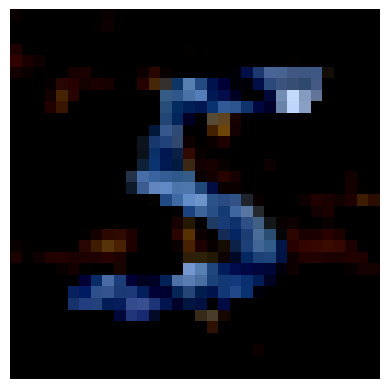

In [8]:
# visualize with normalization
idx = 15
first_image = image_first_batch[idx]
first_label_dataset = label_dataset[idx]
first_label_image = label_image[idx]
print("label of dataset:",first_label_dataset)
print("label of image:",first_label_image)

# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

print("shape: ",image_np.shape) # need to convert back to 28*28 during inference (in digit_classifier.py)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Build Model

instance model and put it on device

In [9]:
net = UNet_conditional(size=32, time_dim=256, num_classes=10, device=device).to(device)

In [10]:
#print output shape
x = torch.randn(10,3,32,32).to(device) # dummy input也放到device
t = torch.randint(0, 500, (10,)).to(device)  # Ensure values are in range [0, 9]
y = torch.randint(0, 10, (10,)).to(device)
dataset_label = torch.randint(0, 2, (10,)).to(device)
output = net(x, t, y, dataset_label)
print(output.shape)
print(x.dtype)
print(y.dtype)

torch.Size([10, 3, 32, 32])
torch.float32
torch.int64


## Training

Loss and Optimizer and epoch_n

In [12]:
# number of epoch
num_epochs = 45
# DDPM paper suggest using MSE as noise loss
criterion = nn.MSELoss()
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# Different base learning rate and update strategy #!!!!!!
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 10個epoch沒進步==> lr *= 0.5
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(combined_loader), eta_min = 1e-8) # update lr each batch

# total time steps
T = 1000


#### DDPM training functions

alpha_t and alpha_hat_t of DDPM

In [13]:
# 1. beta
beta_1 = 1e-4
beta_T = 0.02
beta = torch.linspace(beta_1, beta_T, T) 
# 2. alpha
alpha = 1 - beta
# 3. alpha_hat
# alpha hat = [alpha[0], alpha[0]*alpha[1], alpha[0]*alpha[1]*alpha[2], ... ,alpha[0]*...*alpha[T-1])] 
alpha_hat = torch.zeros_like(alpha) # tensor with len T, alpha_hat.shape = T
alpha_hat[0] = alpha[0] # Set the first element
for i in range(1, alpha.shape[0]):
    alpha_hat[i] = alpha_hat[i - 1] * alpha[i]


torch.save(beta, './alpha_tensors/beta_tensor.pt')
torch.save(alpha, './alpha_tensors/alpha_tensor.pt')
torch.save(alpha_hat, './alpha_tensors/alpha_hat_tensor.pt')

functions

In [14]:
def noise_x_t(alpha_hat, x_0, t, epsilon):
    """given x[0](origin image) and t, return x[t](noisy image from x[0] by adding epsilon repeatly t times)"""
    """一步登天"""
    """epsilon.shape = x_0.shape = N*C*H*W,  t.shape = N"""
    """alpha_hat.shape = T, index t = 0 ~ T-1"""

    sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_alpha_hat.shape = N*1*1*1
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_one_minus_alpha_hat.shape = N*1*1*1

    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * epsilon
    
    return x_t #x[t] is N*C*H*W

#### training loop (DDPM framework)

In [15]:
# Training Loop
version = 3 # for name of checkpoint model

train_loss_list = []
lr_list = []

beta = beta.to(device)
alpha = alpha.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, label_dataset_image in tqdm(combined_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        # ========================================================== step1: x0 ~ q(x0) ===========================================================
        # x0 is original image: images
        dataset_label = label_dataset_image[0]
        image_label = label_dataset_image[1]
        images, dataset_label, image_label = images.to(device), dataset_label.to(device), image_label.to(device)# model, input output of model are moved to GPU during training
        N, C, H, W = images.shape[0], images.shape[1], images.shape[2], images.shape[3]

        # ==================================================== step2: t ~ Uniform({1,...,T}) =====================================================
        t_np = np.random.randint(0, T, size=(N,))  # Sample t from Uniform({0, ..., T-1}) # python is 0-indexing
        t = torch.from_numpy(t_np)
        t = t.to(device)

        # ======================================================= step3: epsilon ~ N(0, 1) =======================================================
        noise = torch.randn(N, C, H, W)  # Sample noise from normal distribution with mean 0 and standard deviation 1
        noise = noise.to(device)         # dtype = float32     # shape = N* C* H* W

        # ===================================== step4: take gradient descent step on noise and predict_noise =====================================
        x_t = noise_x_t(alpha_hat=alpha_hat, x_0=images, t=t, epsilon=noise)
        x_t = x_t.to(device)
        if torch.rand(1).item() < 0.1:  # 10% chance to enter this block # 10% of training is unconditional training
            image_label = None 
            dataset_label = None
        #predict_noise=N*C*H*W
        predict_noise = net(x=x_t, t=t, y=image_label, dataset_label=dataset_label) #x=N*C*H*W, t=N, y=N, dataset_label=N    

        loss = criterion(noise, predict_noise) # MSE loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        scheduler.step() # update lr each batch(cosine scheduler)
        lr_list.append(scheduler.get_last_lr()[0])


    train_loss /= len(combined_loader)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}')
    print(f'Learning rate {scheduler.get_last_lr()[0]}')
    train_loss_list.append(train_loss)

# save the model state_dict
save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{version}.pth')
torch.save(net.state_dict(), save_dir)
print(f'Saved model for epoch to {save_dir}')

Epoch 1/45: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [12:21<00:00,  2.85batch/s]


Epoch 1/45 - Loss: 0.0635
Learning rate 9.987821469274025e-05


Epoch 2/45: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [13:31<00:00,  2.61batch/s]


Epoch 2/45 - Loss: 0.0269
Learning rate 9.951345209673485e-05


Epoch 3/45: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [12:32<00:00,  2.81batch/s]


Epoch 3/45 - Loss: 0.0227
Learning rate 9.890748929868674e-05


Epoch 4/45: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [11:01<00:00,  3.20batch/s]


Epoch 4/45 - Loss: 0.0208
Learning rate 9.806327848843648e-05


Epoch 5/45: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [11:00<00:00,  3.21batch/s]


Epoch 5/45 - Loss: 0.0194
Learning rate 9.698493257619139e-05


Epoch 6/45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [11:01<00:00,  3.20batch/s]


Epoch 6/45 - Loss: 0.0186
Learning rate 9.567770515484151e-05


Epoch 7/45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [11:05<00:00,  3.18batch/s]


Epoch 7/45 - Loss: 0.0179
Learning rate 9.414796490498171e-05


Epoch 8/45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [11:02<00:00,  3.19batch/s]


Epoch 8/45 - Loss: 0.0175
Learning rate 9.24031645673402e-05


Epoch 9/45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2117/2117 [11:02<00:00,  3.19batch/s]


Epoch 9/45 - Loss: 0.0171
Learning rate 9.045180463377525e-05


Epoch 10/45: 100%|███████████████████████████████████████████████████████| 2117/2117 [11:00<00:00,  3.20batch/s]


Epoch 10/45 - Loss: 0.0168
Learning rate 8.830339193373304e-05


Epoch 11/45: 100%|███████████████████████████████████████████████████████| 2117/2117 [11:03<00:00,  3.19batch/s]


Epoch 11/45 - Loss: 0.0166
Learning rate 8.596839331793054e-05


Epoch 13/45: 100%|███████████████████████████████████████████████████████| 2117/2117 [10:59<00:00,  3.21batch/s]


Epoch 13/45 - Loss: 0.0164
Learning rate 8.078499545890485e-05


Epoch 14/45:  57%|███████████████████████████████▏                       | 1199/2117 [06:11<04:50,  3.16batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



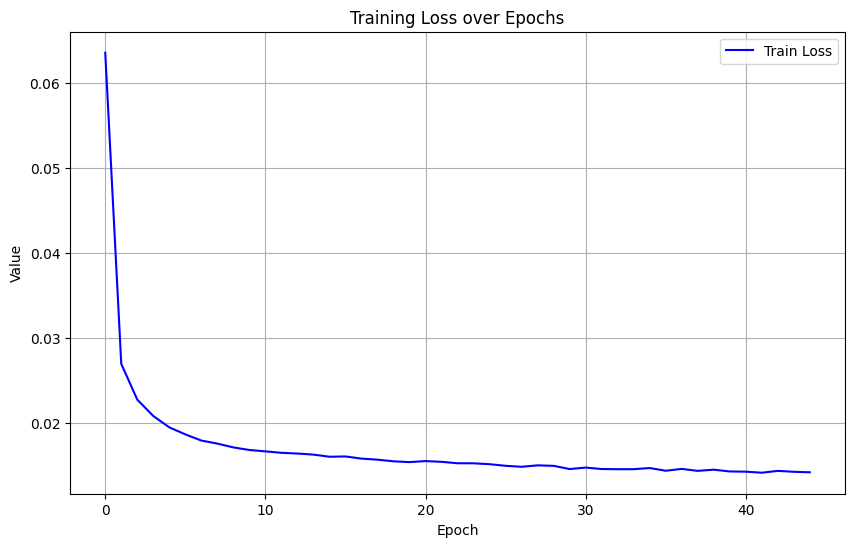

In [16]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_list, label='Train Loss', color='blue')

# Adding titles and labels
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
# Show the plot
plt.show()

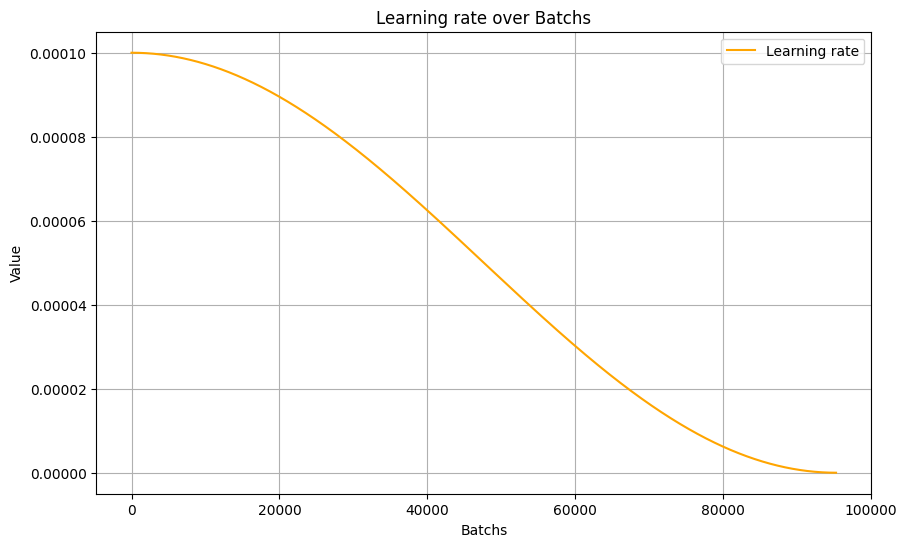

In [17]:
plt.figure(figsize=(10, 6))
# Plot Learning rate
plt.plot(lr_list, label='Learning rate', color='orange')


# Adding titles and labels
plt.title('Learning rate over Batchs')
plt.xlabel('Batchs')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [18]:
print(train_loss_list)

[0.06350326325953795, 0.026905230512199365, 0.022694177238642817, 0.020770341358299336, 0.01943352289918421, 0.01860709900811163, 0.017880708962656033, 0.017523732038551787, 0.017075685888043146, 0.016772287862571584, 0.016608634751807436, 0.016440641894288992, 0.016352937591832307, 0.01622787602734125, 0.015979770491366882, 0.01601069458475689, 0.015758628794201066, 0.015631467490652765, 0.015439931414343935, 0.015345714724788519, 0.015468435425770609, 0.015379334152154853, 0.015210290473081211, 0.015206188676165251, 0.015098932284745663, 0.014911493297708545, 0.014796785128544392, 0.014965079693993872, 0.014907105232821667, 0.014531435092570622, 0.014700223893247436, 0.01453180447613216, 0.014509636645804057, 0.014512325147405287, 0.014649751336596656, 0.014330318772810765, 0.014547709548950589, 0.014315669421752388, 0.014454161160329448, 0.014248406211196687, 0.014220907938185803, 0.014097462935495486, 0.014315648390007473, 0.014206252575983515, 0.0141480904871868]
